In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Paths
dataset_root = "/content/svm_dataset/Car-Bike-Dataset"
classes = ["Bike", "Car", "Ship"]


In [33]:
# Load images and assign labels based on folder
all_images = []
labels = []

for idx, cls in enumerate(classes):
    folder = os.path.join(dataset_root, cls)
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            fpath = os.path.join(folder, fname)
            all_images.append(fpath)
            labels.append(idx)

print("Total images:", len(all_images))
for i, cls in enumerate(classes):
    print(f"{cls}: {labels.count(i)}")


Total images: 2970
Bike: 1010
Car: 990
Ship: 970


In [34]:
def dense_sift(img, step_size=8):
    """Extract dense SIFT features."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()

    # Dense keypoints (grid-based)
    keypoints = [cv2.KeyPoint(x, y, step_size)
                 for y in range(0, gray.shape[0], step_size)
                 for x in range(0, gray.shape[1], step_size)]

    kp, des = sift.compute(gray, keypoints)
    return des

# Extract descriptors
all_descriptors = []
image_des_list = []

for f in tqdm(all_images, desc="Extracting Dense SIFT"):
    img = cv2.imread(f)
    des = dense_sift(img)
    if des is not None:
        all_descriptors.append(des)
        image_des_list.append(des)

# Stack all descriptors for clustering
all_descriptors = np.vstack(all_descriptors)
print("Shape of all descriptors:", all_descriptors.shape)


Extracting Dense SIFT: 100%|██████████| 2970/2970 [11:25<00:00,  4.33it/s]


Shape of all descriptors: (7118759, 128)


In [36]:
k = 200  # Vocabulary size
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000, verbose=1)
kmeans.fit(all_descriptors)

print("Vocabulary created with", k, "visual words")


Init 1/1 with method k-means++
Inertia for init 1/1: 3329193216.0
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 1/71187: mean batch inertia: 110971.2
Minibatch step 2/71187: mean batch inertia: 82889.4336, ewa inertia: 82889.4336
Minibatch step 3/71187: mean batch inertia: 81354.5728, ewa inertia: 82885.12144226466
Minibatch step 4/71187: mean batch inertia: 80910.592, ewa inertia: 82879.57404512733
Minibatch step 5/71187: mean batch inertia: 80551.1296, ewa inertia: 82873.03233155607
Minibatch step 6/71187: mean batch inertia: 79496.0064, ewa inertia: 82863.54465130964
Minibatch step 7/71187: mean batch inertia: 80176.0832, ewa inertia: 82855.99428733806
Minibatch step 8/71187: mean batch inertia: 80395.8208, ewa inertia: 82849.08248391349
Minibatch step 9/71187: mean batch inertia: 80314.1568, ewa inertia: 82841.96066583304
Minibatch step 10/71187: mean batch inertia: 79497.9776, ewa inertia: 82832.56581879273
Minibatch step 11/71187: mean batch inertia: 80355.9936,

In [37]:
def build_histogram(des, kmeans, k):
    hist = np.zeros(k)
    idx = kmeans.predict(des)
    for i in idx:
        hist[i] += 1
    # Normalize histogram
    hist = hist / np.linalg.norm(hist)
    return hist

X = []
for des in tqdm(image_des_list, desc="Building histograms"):
    X.append(build_histogram(des, kmeans, k))

X = np.array(X)
y = np.array(labels)

print("Feature matrix shape:", X.shape)


Building histograms: 100%|██████████| 2970/2970 [00:17<00:00, 171.46it/s]

Feature matrix shape: (2970, 200)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (2376, 200) Test size: (594, 200)


In [39]:
# Define parameter grid
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", 0.01, 0.001]
}

svm = SVC(probability=True)
grid = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_svm = grid.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [40]:
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy (OvR):", acc)
print("\nClassification Report (OvR):")
print(classification_report(y_test, y_pred, target_names=classes))


Accuracy (OvR): 0.9326599326599326

Classification Report (OvR):
              precision    recall  f1-score   support

        Bike       0.90      0.93      0.91       202
         Car       0.93      0.88      0.91       198
        Ship       0.96      0.99      0.98       194

    accuracy                           0.93       594
   macro avg       0.93      0.93      0.93       594
weighted avg       0.93      0.93      0.93       594



In [42]:
from sklearn.model_selection import train_test_split

# Keep paths aligned
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, image_desc_map, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 2376
Testing samples: 594


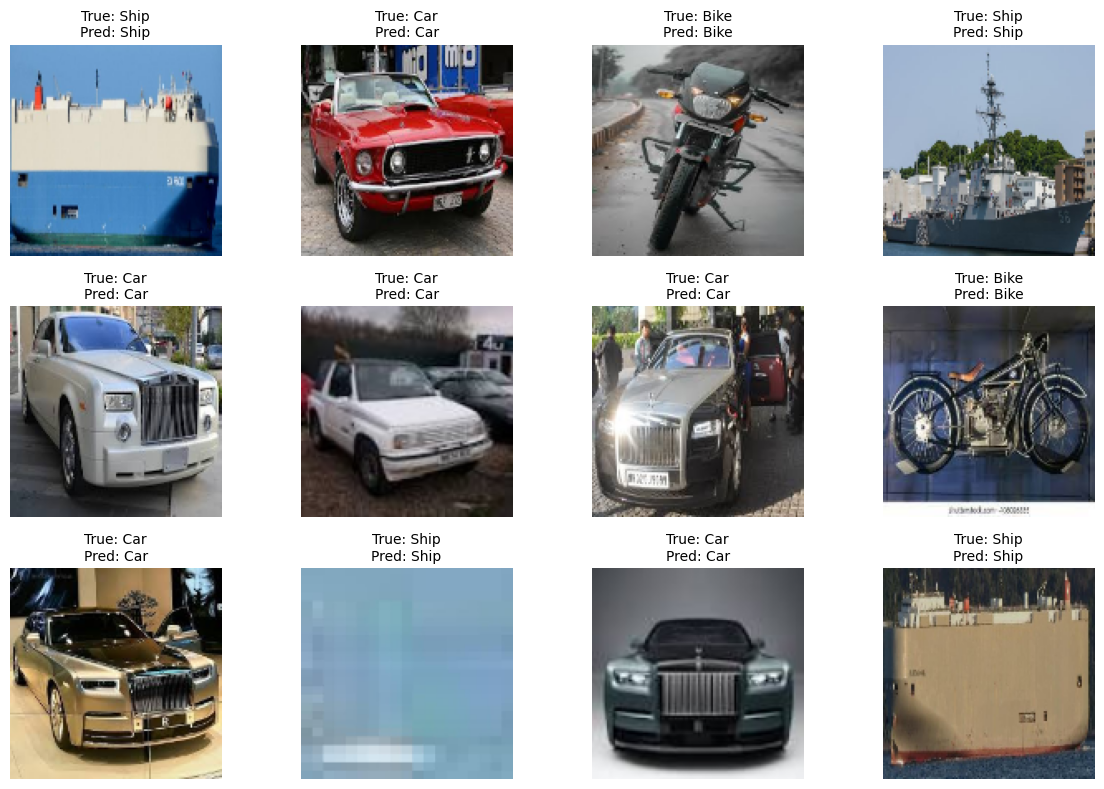

In [43]:
import random
plt.figure(figsize=(12, 8))

sample_idxs = random.sample(range(len(X_test)), 12)

for i, idx in enumerate(sample_idxs):
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred[idx]]

    img_path = paths_test[idx]  # ✅ correct mapping!
    img = cv2.imread(img_path)[:, :, ::-1]
    img = cv2.resize(img, (128, 128))

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()
